There are many tools and utilities in the package


## Table of Contents

* Histograms
* Histogram Equalization 
* Contrast Limited Histogram Equalization
* Histograms and Thresholding 
* Filtering
* Feature Extraction

### Histograms

Histograms are a quick way to get a feel for the global statistics of the image intensity. For example, they can tell you where to set a threshold or how to adjust the contrast of an image.

Plot a histogram using matplotlib's `hist` function

(array([51199.,  8554.,  6922.,  8834., 31923., 43625., 84777., 23862.,
         1470.,   978.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 10 Patch objects>)

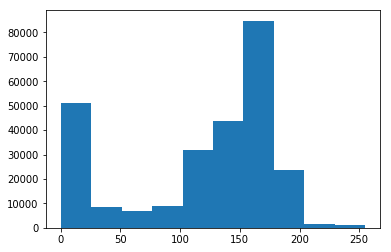

In [0]:
from matplotlib import pyplot as plt
from skimage import data
gray_image = data.camera()
plt.hist(gray_image.ravel())

An image histogram shows the number of pixels at each intensity value (or range of intensity values, if values are binned). Low-intensity values are closer to black, and high-intensity values are closer to white.

Notice that there's a large peak at an intensity of about 10: This peak corresponds with the man's nearly black coat. The peak around the middle of the histogram is due to the predominantly gray tone of the image.

In [0]:
!sudo apt-get install python3-matplotlib python3-numpy python3-pil python3-scipy python3-tk


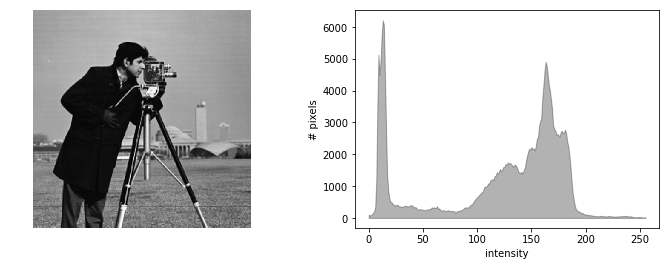

In [34]:
import skdemo
image = data.camera()
skdemo.imshow_with_histogram(image);

Notice the intensity values at the bottom. Since the image has a `dtype` of `uint8`, the values go from 0 to 255. Though you can see some pixels tail off toward 255, you can clearly see in the histogram, and in the image, that we're not using the high-intensity limits very well.

Based on the histogram values, you might want to take all the pixels values that are more than about 180 in the image, and make them pure white (i.e. an intensity of 255). While we're at it, values less than about 10 can be set to pure black (i.e. 0). We can do this easily using `rescale_intensity`, from the `exposure` subpackage.

#### Improving Contrast of an image

Parameters for `rescale_intensity`:
* `in_range`: The min and max intensity values desired in the input image. Values below/above these limits will be clipped.
* `out_range`: The min and max intensity values of the output image. Pixels matching the limits from `in_range` will be rescaled to these limits. Everything in between gets linearly interpolated.

In [0]:
from skimage import exposure
high_contrast = exposure.rescale_intensity(image, in_range=(10, 180))

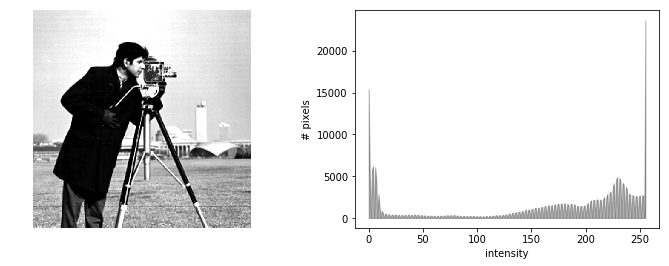

In [0]:
skdemo.imshow_with_histogram(high_contrast);

The contrast is visibly higher in the image, and the histogram is noticeably stretched. The sharp peak on the right is due to all the pixels greater than 180 (in the original image) that were piled into a single bin (i.e. 255).

### Histogram equalization

In the previous example, the grayscale values (10, 180) were set to (0, 255), and everything in between was linearly interpolated. There are other strategies for contrast enhancement that try to be a bit more intelligent---notably histogram equalization.

Let's first look at the cumulative distribution function (CDF) of the image intensities.

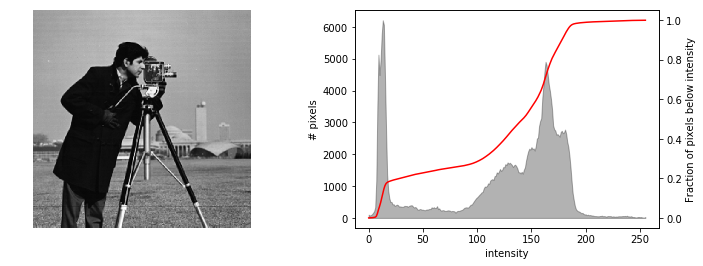

In [35]:
ax_image, ax_hist = skdemo.imshow_with_histogram(image)
skdemo.plot_cdf(image, ax=ax_hist.twinx())

For each intensity value, the CDF gives the fraction of pixels *below* that intensity value.

One measure of contrast is how evenly distributed intensity values are: The dark coat might contrast sharply with the background, but the tight distribution of pixels in the dark coat mean that details in the coat are hidden.

To enhance contrast, we could *spread out intensities* that are tightly distributed and *combine intensities* which are used by only a few pixels.

This redistribution is exactly what histogram equalization does. And the CDF is important because a perfectly uniform distribution gives a CDF that's a straight line. We can use `equalize_hist` from the `exposure` package to produce an equalized image:

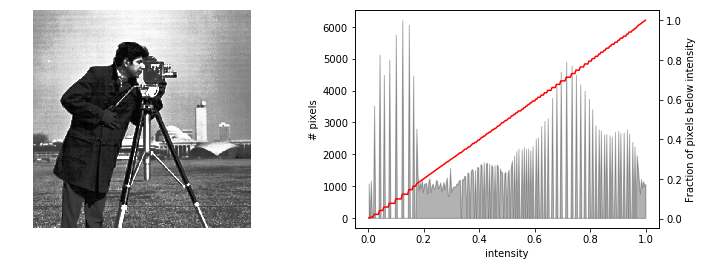

In [36]:
equalized = exposure.equalize_hist(image)
ax_image, ax_hist = skdemo.imshow_with_histogram(equalized)
skdemo.plot_cdf(equalized, ax=ax_hist.twinx())

### Contrasted-limited, adaptive histogram equalization

Unfortunately, histogram equalization tends to give an image whose contrast is artificially high. In addition, better enhancement can be achieved locally by looking at smaller patches of an image, rather than the whole image. In the image above, the contrast in the coat is much improved, but the contrast in the grass is somewhat reduced.

Contrast-limited adaptive histogram equalization (CLAHE) addresses these issues. The implementation details aren't too important, but seeing the result is helpful:

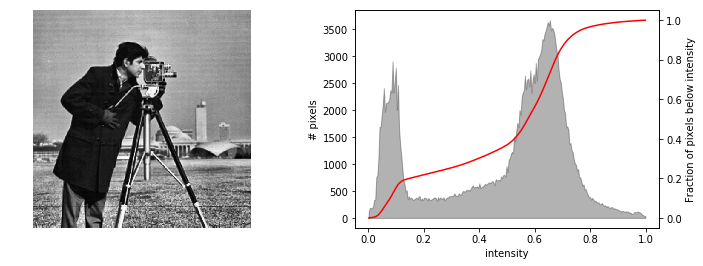

In [37]:
equalized = exposure.equalize_adapthist(image)
ax_image, ax_hist = skdemo.imshow_with_histogram(equalized)
skdemo.plot_cdf(equalized, ax=ax_hist.twinx())

### Thresholding

One of the most common uses for image histograms is thresholding. Let's return to the original image and its histogram

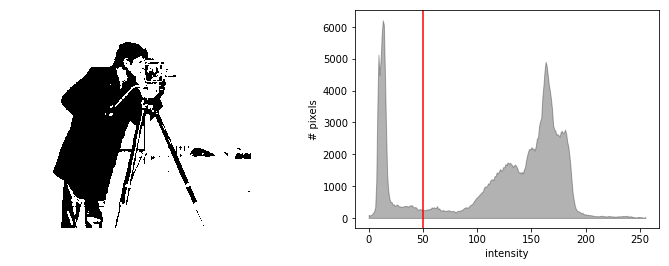

In [0]:
threshold = 50
ax_image, ax_hist = skdemo.imshow_with_histogram(image)
# This is a bit of a hack that plots the thresholded image over the original.
# This just allows us to reuse the layout defined in `plot_image_with_histogram`.
ax_image.imshow(image > threshold)
ax_hist.axvline(threshold, color='red');

87


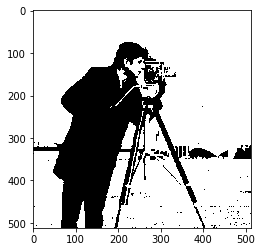

In [0]:
# Rename module so we don't shadow the builtin function
from skimage import filters
#import skimage.filter as filters
threshold = filters.threshold_otsu(image)
print(threshold)
plt.imshow(image > threshold);

### Filtering

For our first example of a filter, consider the following filtering array, which we'll call a "mean kernel". For each pixel, a kernel defines which neighboring pixels to consider when filtering, and how much to weight those pixels.

In [0]:
import numpy as np
mean_kernel = np.full((3, 3), 1/9)

print(mean_kernel)

[[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]


Now, let's take our mean kernel and apply it to every pixel of the image.

Applying a (linear) filter essentially means:
* Center a kernel on a pixel
* Multiply the pixels *under* that kernel by the values *in* the kernel
* Sum all the those results
* Replace the center pixel with the summed result

In [0]:
import scipy.ndimage as ndi
import numpy as np

bright_square = np.zeros((7, 7), dtype=float)
bright_square[2:5, 2:5] = 1
%precision 2
print(bright_square)
print(ndi.correlate(bright_square, mean_kernel))

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
[[0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.11 0.22 0.33 0.22 0.11 0.  ]
 [0.   0.22 0.44 0.67 0.44 0.22 0.  ]
 [0.   0.33 0.67 1.   0.67 0.33 0.  ]
 [0.   0.22 0.44 0.67 0.44 0.22 0.  ]
 [0.   0.11 0.22 0.33 0.22 0.11 0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]]


The meaning of "mean kernel" should be clear now: Each pixel was replaced with the mean value within the 3x3 neighborhood of that pixel. When the kernel was over `n` bright pixels, the pixel in the kernel's center was changed to n/9 (= n * 0.111). When no bright pixels were under the kernel, the result was 0.

This filter is a simple smoothing filter and produces two important results:
1. The intensity of the bright pixel decreased.
2. The intensity of the region near the bright pixel increased.

In [0]:
#--------------------------------------------------------------------------
#  Convolution Demo
#--------------------------------------------------------------------------
from skimage import color
from scipy import ndimage as ndi
from matplotlib import patches

def mean_filter_demo(image, vmax=1):
    mean_factor = 1.0 / 9.0  # This assumes a 3x3 kernel.
    iter_kernel_and_subimage = iter_kernel(image)

    image_cache = []

    def mean_filter_step(i_step):
        while i_step >= len(image_cache):
            filtered = image if i_step == 0 else image_cache[-1][-1][-1]
            filtered = filtered.copy()

            (i, j), mask, subimage = next(iter_kernel_and_subimage)
            filter_overlay = color.label2rgb(mask, image, bg_label=0,
                                             colors=('cyan', 'red'))
            filtered[i, j] = np.sum(mean_factor * subimage)
            image_cache.append(((i, j), (filter_overlay, filtered)))

        (i, j), images = image_cache[i_step]
        fig, axes = plt.subplots(1, len(images), figsize=(10, 5))
        
        for ax, imc in zip(axes, images):
            ax.imshow(imc, vmax=vmax)
            rect = patches.Rectangle([j - 0.5, i - 0.5], 1, 1, color='yellow', fill=False)
            ax.add_patch(rect)
            
        plt.show()
    return mean_filter_step


def mean_filter_interactive_demo(image):
    from ipywidgets import IntSlider, interact
    mean_filter_step = mean_filter_demo(image)
    step_slider = IntSlider(min=0, max=image.size-1, value=0)
    interact(mean_filter_step, i_step=step_slider)


def iter_kernel(image, size=1):
    """ Yield position, kernel mask, and image for each pixel in the image.

    The kernel mask has a 2 at the center pixel and 1 around it. The actual
    width of the kernel is 2*size + 1.
    """
    width = 2*size + 1
    for (i, j), pixel in iter_pixels(image):
        mask = np.zeros(image.shape, dtype='int16')
        mask[i, j] = 1
        mask = ndi.grey_dilation(mask, size=width)
        #mask[i, j] = 2
        subimage = image[bounded_slice((i, j), image.shape[:2], size=size)]
        yield (i, j), mask, subimage


def iter_pixels(image):
    """ Yield pixel position (row, column) and pixel intensity. """
    height, width = image.shape[:2]
    for i in range(height):
        for j in range(width):
            yield (i, j), image[i, j]


def bounded_slice(center, xy_max, size=1, i_min=0):
    slices = []
    for i, i_max in zip(center, xy_max):
        slices.append(slice(max(i - size, i_min), min(i + size + 1, i_max)))
    return tuple(slices)



In [42]:
mean_filter_interactive_demo(bright_square)

interactive(children=(IntSlider(value=0, description='i_step', max=48), Output()), _dom_classes=('widget-inter…

Incidentally, the above filtering is the exact same principle behind the *convolutional neural networks*, or CNNs, that you might have heard much about over the past few years. The only difference is that while above, the simple mean kernel is used, in CNNs, the values inside the kernel are *learned* to find a specific feature, or accomplish a specific task. Time permitting, we'll demonstrate this in an exercise at the end of the notebook.

#### Edge Detection

For images, edges are boundaries between light and dark values. The detection of edges can be useful on its own, or it can be used as preliminary step in other algorithms 

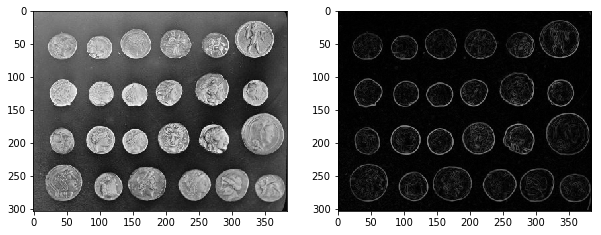

In [0]:
from skimage import data
import skdemo
coins = data.coins()
edges =filters.sobel(coins)
skdemo.imshow_all(coins,edges)

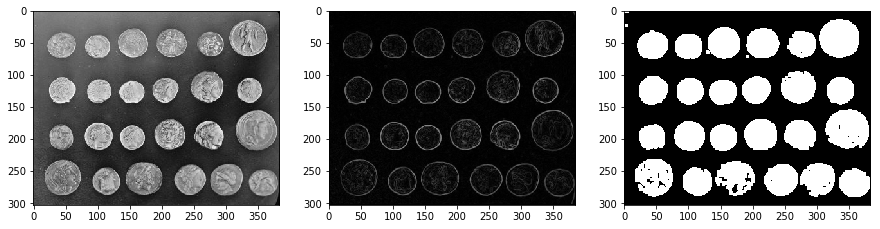

In [0]:
from skimage import data
import skdemo
from skimage.morphology import closing, dilation, square


coins = data.coins()
#equalized = exposure.equalize_hist(coins)
#edges =filters.sobel(coins)
thresh = filters.threshold_minimum(coins)
bw = dilation(coins > thresh, square(5))
skdemo.imshow_all(coins,edges,bw)

### Feature Extraction

In [0]:
from skimage.measure import label, regionprops
from skimage.color import label2rgb

label_image = label(bw)
image_label_overlay = label2rgb(label_image, image=coins)


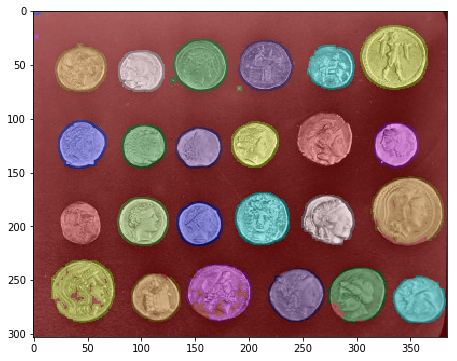

In [0]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

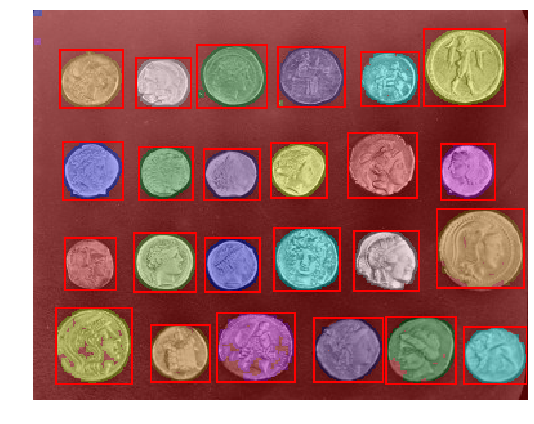

In [0]:
import matplotlib.patches as mpatches
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()
